https://github.com/magsgiust/ds-python_examples/blob/master/saas_company-data_generator.py

In [4]:
# MIT License
# 
# Copyright (c) 2018 Michael DeFelice
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.style.use ('ggplot')

In [5]:
# Note the first at 0 is a free trial ... As upgrades are considered advancing through this array, please ensure the pricing increases throughout the list
subscription_prices     = [0,    5,    10,   15,   20  ]

In [6]:
# These need to sum to 1
subscription_pvals      = [0.80, 0.10, 0.06, 0.02, 0.02]
sub_n = len (subscription_pvals)

In [7]:
start_date = '2014-01-01'
periods = 48

In [8]:
# Tweak these: start number of subscriptions; monthly upgrade percent; monthly downgrade percent; monthly new subscriptions; monthly churn percent
start_n = 20000
upgrade_p = 0.02
downgrade_p = 0.02
new_n = 200
churn_p = 0.02

In [9]:
# Initial subscriptions
df = pd.DataFrame (index = range (start_n), columns = range (periods))
df.iloc[:, 0] = np.random.multinomial (1, subscription_pvals, start_n).argmax (axis = 1)

In [10]:
# New
for _ in range (1, periods):
  subscriptions = np.random.multinomial (1, subscription_pvals, new_n).argmax (axis = 1)
  df = pd.concat ([df,
                   pd.DataFrame (subscriptions, columns = [_]),
                  ], axis = 0)

In [11]:
# Reindex
df = df.reset_index (drop = True)

In [12]:
# Upgrades & downgrades
for _ in range (1, periods):
  df.iloc[:, _].update (df.iloc[:, _ - 1].dropna ())
  upgrade_candidates = df.iloc[:, _].dropna ()
  upgrade_candidates = upgrade_candidates[upgrade_candidates < sub_n - 1]
  upgrades = upgrade_candidates.sample (frac = upgrade_p)
  upgrades += 1
  df.iloc[:, _].update (upgrades)
  downgrade_candidates = df[~df.index.isin (upgrades.index)].iloc[:, _].dropna ()
  downgrade_candidates = downgrade_candidates[downgrade_candidates > 0]
  downgrades = downgrade_candidates.sample (frac = downgrade_p)
  downgrades -= 1
  df.iloc[:, _].update (downgrades)

In [13]:
# Churn
for _ in range (1, periods):
  churn_candidates = df.iloc[:, _ - 1].dropna ()
  churn = churn_candidates.sample (frac = churn_p)
  churn = pd.DataFrame (index = churn.index, columns = range (_, periods))
  churn = churn.fillna (-1)
  df.update (churn)

In [14]:
# Cleanup the subscriptions DataFrame
df = df.replace (-1, np.nan)
df.columns = pd.DatetimeIndex (start = start_date, periods = periods, freq = 'M')
df.columns.name = 'Month_Invoiced'
df.index.name = 'Customer_Id'
df.index += 1000000

In [15]:
mrr = df.applymap (lambda a: subscription_prices[int (a)] if a >= 0 else a)

In [16]:
invoiced_items = pd.concat ([
  df.unstack ().rename ('Subscription_Type'),
  mrr.unstack ().rename ('Amount'),
], axis = 1).dropna ()

In [17]:
# For better presentation, customer ids start at 1,000,000 and invoice ids at 5,000,000
invoiced_items.insert (0, 'Invoice_Id', range (5000000, 5000000 + invoiced_items.shape[0]))
invoiced_items = invoiced_items.reset_index ()

In [18]:
# Do stuff now with invoiced_items
# ...

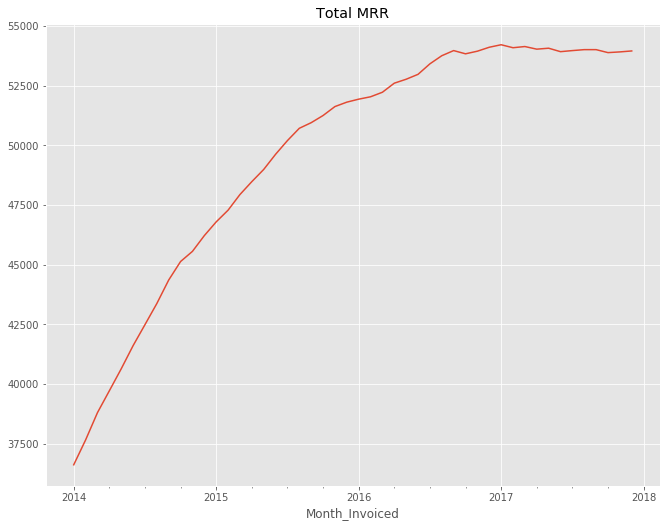

In [19]:
# Example Plot
fig, ax = plt.subplots (1, 1, figsize = (11, 8.5))
invoiced_items.groupby (['Month_Invoiced']).agg ({'Amount': np.sum,}).plot (ax = ax, kind = 'line', legend = False, title = 'Total MRR')
plt.show ()
plt.close ('all')